# Chain
## Review

En el archivo Simple_Graph se contruyó un grafico simple con nodos, edges normales y edges condicionales

# Objetivo de este archivo

Ahora se contruirá una cadena simple que combine 4 conceptos claves:

* Usar mensajes de chat como "estado" para el grafico
* Usar modelos de chat en los "nodos" del grafico
* Enlazar "Tools" a nuestro modelo de chat
* Ejecutar llamadas a las "tools en el grafico"

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Mensajes [Messages]
Los modelos de chat pueden usar "messages", los cuales capturan los diferentes roles dentro de una conversasión
LangChain soporta varios tipos de "messages", incluyendo HumanMessage, AIMessage, SystemMessage, y ToolMessage

Estos representan mensajes enviados por el usuario, por el modelo de chat para que el modelo indique un comportamiento y una llamada a alguna herramienta

Crearemos una lista de mensajes
Cada mensaje puede incluir alguna de las siguientes cosas:
* [content] - Es el contenido del mensaje
* [name] - Opcionalmente un mensaje del autor
* [response_metada] - Opcionalmente, un diccionario de metadatos (Ej: En ocaciones completado por el proveedor del modelo para AIMessages)

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.extend([HumanMessage(content=f"Yes, that´s right.", name ="Lance")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about.", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about teh best place to see Orcas in the US",name ="Lance")])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that´s right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about teh best place to see Orcas in the US


In [4]:
from general_conf.imports import *
load_dotenv(find_dotenv())
print("Ingresando la APIKEY")



Ingresando la APIKEY


Podemos cargar el modelo de chat e invocarlo con "invoke" con la lista de mensajes
Se puede ver que el resultado es un AIMessage con "response_metada" especificos

In [20]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [21]:
result

AIMessage(content='One of the best places to see Orcas in the US is in the Pacific Northwest, specifically in the waters around the San Juan Islands in Washington State. The area is known for its resident Orca population, called the Southern Resident killer whales. You can take whale-watching tours from places like Seattle, Anacortes, or Friday Harbor to increase your chances of spotting these magnificent animals in their natural habitat. Additionally, you may also see Orcas in other coastal regions of the US, such as Alaska, Oregon, and California, but the San Juan Islands are particularly renowned for Orca sightings.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 67, 'total_tokens': 189, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-tu

In [22]:
result.response_metadata

{'token_usage': {'completion_tokens': 122,
  'prompt_tokens': 67,
  'total_tokens': 189,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-3.5-turbo-0125',
 'system_fingerprint': None,
 'finish_reason': 'stop',
 'logprobs': None}

# TOOLS 
Las herramientas o "tools" son serán siempr utiles cuando se quiera que nuestro sistema de agentes interactue con sistemas externos
Estos sitemas externos como la API's, amenudo requieren un esquema de entrada particular en lugar del leguaje natural

Cuando por ejemplo enlazamos una API, como herramienta, le damos al modelo conocimiento del esquema de la entrada requerida

El modelo decidirá a que herramienta llamar basandose en la entrada del lengaje natural de usuario, y devolverá una salida que se adihera al esquema de la herramienta

Muchos proveedores LLM soportan la llamada a herramientas y la interfaz de llamada a herramientas en LangChain es sencilla. 
 
Puedes simplemente pasar cualquier 'función' de Python a 'ChatModel.bind_tools(function)'.

In [23]:
def multiply(a:int, b:int) -> int:
    """
    Multply a and b
    Args:
        a: first number
        b: second number 
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

Si pasaramos una entrada como por ejemplo "Cuanto es 2 multiplicado por 3", veriamos la llamada a la herramienta 
La llamada a la herramienta tiene argumentos específicos que coinciden con el esquema de entrada de nuestra función junto con el nombre de la función a llamar.
```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```



In [24]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Cuanto es 2 multiplicado por 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Lmx65w7Zz7KJUg367suHhesS', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 74, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3abe8f02-7dba-4a83-b680-7b9e7366a9d4-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_Lmx65w7Zz7KJUg367suHhesS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 33, 'total_tokens': 107, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [25]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_Lmx65w7Zz7KJUg367suHhesS',
  'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'},
  'type': 'function'}]

# Usar mensajes como un estado del grafico
Con todos estos fundamentos podemos usar "message" en el estado de nuestros graficos
Definiremos nuestro estado "MessageState como un TypedDict con una sola clave "message"
"message" es simplemente una lista de mensajes, como se definieron anteriormente, como Ej: HumanMessage


In [28]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    message: list[AnyMessage]
    

# Reductores

¡Ahora tenemos un pequeño problema!

A medida que se ejecuta nuestro gráfico, queremos agregar mensajes a nuestra clave de estado de "messages".
Pero, como comentamos, cada nodo también anulará el valor del estado anterior.
## Las funciones reductoras abordan esto.
Nos permiten especificar cómo se realizan las actualizaciones de estado.
Si no se especifica explícitamente ninguna función reductora, se supone que todas las actualizaciones de esa clave deben anularla.
Como queremos agregar "messages", ¡podemos usar un reductor [add_messages] prediseñado!
Esto garantiza que las actualizaciones de estado que envíe al gráfico se agreguen a la lista de mensajes existente.
Anotamos (a través de Annotated) nuestra clave con una función reductora como metadatos.

In [30]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    message: Annotated[list[AnyMessage], add_messages]
    

Dado que es muy común tener una lista de mensajes en estado gráfico, LangGraph tiene un [`MessagesState`] precompilado.

Se define `MessagesState`:

* Con una clave `messages` única precompilada
* Esta es una lista de objetos `AnyMessage`
* Utiliza el reductor `add_messages`

Normalmente utilizaremos `MessagesState` porque es menos detallado que definir un `TypedDict` personalizado, como se muestra arriba.

In [31]:
from langgraph.graph import MessagesState
class MessageState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

Para profundizar un poco más, podemos ver cómo funciona el reductor `add_messages` de forma aislada.

In [32]:
# Initial state
initial_messages =[AIMessage(content="Hola, cómo puedo ayudarte?", name="Model"), 
                   HumanMessage(content="Estoy buscando información de biologia marina", name="Lance")]
# New Message to add
new_message = AIMessage(content="Claro, puedo ayudarte con eso. En que estás interesado especificamente?", name="Model")

# Test

add_messages(initial_messages, new_message)

[AIMessage(content='Hola, cómo puedo ayudarte?', additional_kwargs={}, response_metadata={}, name='Model', id='01796b4e-0fd2-4be6-a812-000ccd402851'),
 HumanMessage(content='Estoy buscando información de biologia marina', additional_kwargs={}, response_metadata={}, name='Lance', id='434a3fcd-e6ca-4ae8-a790-bc45de56608c'),
 AIMessage(content='Claro, puedo ayudarte con eso. En que estás interesado especificamente?', additional_kwargs={}, response_metadata={}, name='Model', id='25043387-2a08-4910-bf89-2bc5cfdd5841')]

# Nuestro Grafico
Ahora intentemos utilizar MessagesState en un grafico

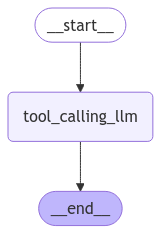

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# State

class MessagesState(MessagesState):
    # Add any keys needed  beyond messages, which is pre-built
    pass

# Nodo
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

"""
# Nodo
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}
"""

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [42]:
messages = graph.invoke({"messages": HumanMessage(content="Hola")})
for m in messages['messages']:
    m.pretty_print()
    

================================ Human Message =================================

Hola
================================== Ai Message ==================================

¡Hola! ¿Cómo estás? ¿En qué puedo ayudarte hoy?


In [43]:
messages

{'messages': [HumanMessage(content='Hola', additional_kwargs={}, response_metadata={}, id='5c3f6e7b-7211-4127-881c-91c0e5108157'),
  AIMessage(content='¡Hola! ¿Cómo estás? ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 8, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-802824d0-080c-4629-bbb8-b27610ec94e5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 17, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

El LLM elige utilizar una herramienta cuando determina que la entrada o la tarea requiere la funcionalidad proporcionada por esa herramienta.

In [44]:
messages = graph.invoke({"messages": HumanMessage(content="Puedes multiplicar 2 por 8")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Puedes multiplicar 2 por 8
================================== Ai Message ==================================

Sí, 2 por 8 es igual a 16.


In [45]:
messages

{'messages': [HumanMessage(content='Puedes multiplicar 2 por 8', additional_kwargs={}, response_metadata={}, id='446f29c5-d3ae-42ae-85da-3b0de7e39f39'),
  AIMessage(content='Sí, 2 por 8 es igual a 16.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 17, 'total_tokens': 32, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-28602c5e-32ee-4998-80ac-144e8f5f5a32-0', usage_metadata={'input_tokens': 17, 'output_tokens': 15, 'total_tokens': 32, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}